# An Introduction to Neural Networks
---
# 02 - Singlelayer Perceptron

Esse é o nosso primeiro tutorial realmente sobre Redes Neurais!  
Nesse tutorial, iremos estudar a Rede Neural de camada-única mais simples: a **Singlelayer Perceptron** (SLP). Essa arquitetura foi uma das primeiras idealizadas e é bastante útil para se familiarizar com os conceitos mais básicos.

A Singlelayer Perceptron é uma rede-neural de apenas uma única camada de ativação que conecta os _sinais de entrada_ (atributos de uma observação) com os _sinais de saída_ (classe de uma observação). Abaixo uma representação gráfica de um Singlelayer Perceptron:  

<img src="../slides/imgs/slp_01.png" alt="singlelayer perceptron" width="400px"/>

Neste notebook, começaremos implementando as funções auxiliares que serão importantes para a implementação do modelo e dos algoritmos de treinamento da SLP. Iremos, então, aplicar o modelo desenvolvido para um problema artificial de _classificação binária_ (quando há apenas duas classes envolvidas).

### Sumário
* [Parte 1 - Funções Básicas de Redes Neurais](#Parte-1---Funções-Básicas-de-Redes-Neurais)
* [Parte 2 - Treinando a Rede Neural](#Parte-2---Treinando-a-Rede-Neural)
* [Parte 3 - Classificação Binária com SLP](#Parte-3---Classificação-Binária-com-SLP)


### Bibliotecas, Variáveis Importantes e Funções Auxiliares

In [1]:
## BIBLIOTECAS ##
import pandas as pd                 # <-- Representação e Manipulação dos Dados
import numpy as np                  # <-- Biblioteca para Operações Matriciais e Complexas
import matplotlib.pyplot as plt     # <-- Biblioteca para Visualização de Dados

## VARIÁVEIS IMPORTANTES ##
colorpad = ["#d11141", "#00aedb", "#00b159", "#f37735", "#ffc425"]
colorpadBG = ["#00aedb50", "#d1114150", "#00b15950", "#f3773550", "#ffc42550"]

## FUNÇÕES AUXILIARES ##
# Plota um fundo colorido para as visualizações
def plotContour(X, model, theta, nClasses=2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model(np.c_[xx.ravel(), yy.ravel()], theta, False) 
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors="#2A2A2A", linewidths=2)
    plt.contourf(xx, yy, Z, levels=range(-1,nClasses), colors=colorpadBG)

    
# Essa linha abaixo é apenas para que os 
# plots sejam gerados na mesma célula do código
%matplotlib inline

### Datasets

Neste tutorial, utilizaremos um dataset artificial, criado apenas para servir como base à explicação dos conceitos relacionados ao treino de Redes Neurais de camada-única.
    
O código abaixo já está pronto. Para mais detalhes sobre como resgatar e manipular dados de arquivos, refira-se ao Tutorial 01.


In [2]:
## CARREGANDO E PRÉ-PROCESSANDO OS DADOS ##
# Carregando os dados a partir do arquivo .csv
data = pd.read_csv("../datasets/data_01.csv")

# Armazenando as dimensões dos dados
m = data.shape[0]
n = data.shape[1]-1

# Transformando as Classes em Números
data["Class"] = data["Class"].astype('category').cat.codes

# Separação do Conjunto de Treino e Conjunto de Teste
np.random.seed(11)
trainingSize = int(0.8 * m)
indexes = np.random.randint(0, m, m)

trainData = data.iloc[indexes[:trainingSize]]
testData = data.iloc[indexes[trainingSize:]]

# Obtendo matrizes (formato Numpy) correspondentes
X_train = trainData.iloc[:,:-1].values
y_train = trainData.iloc[:, -1].values

X_test = testData.iloc[:,:-1].values
y_test = testData.iloc[:, -1].values

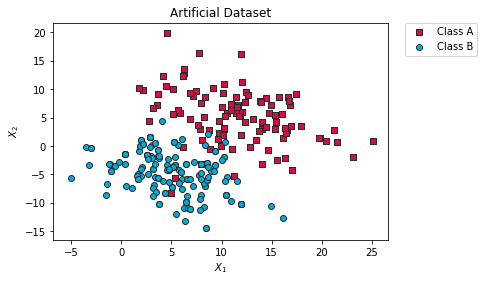

In [3]:
## VISUALIZAÇÃO CONDICIONADA COM O MATPLOTLIB E NUMPY ##
plt.figure()

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

---
## Parte 1 - Funções Básicas de Redes Neurais

Como vimos, uma Rede Neural consiste num conjunto de _neurônios artificiais_ interligados por "sinapses" que possuem pesos associados. Antes de desenvolvermos os algoritmos que ajustam automaticamente estes pesos, é necessário programar as funções básicas de ativação dos neurônios, e da Rede Neural inteira.

Lembre-se que um neurônio artificial realiza duas computações:

* **Potencial de Rede:** soma ponderada dos sinais de entradas, onde cada sinal é multiplicado pelo peso associado à sua sinapse;
* **Função de Ativação:** função cuja saída corresponde à ativação do neurônio (um valor entre 0 e 1) de acordo com o Potencial de Rede;

Além disso, iremos também implementar uma função auxiliar que nos ajudará a avaliar a acurácia da Rede Neural em um determinado teste.

### Função de Ativação
Primeiramente, iremos programar separadamente a nossa **função de ativação**, denotada por $\varphi(.)$. Existem [várias opções](https://en.wikipedia.org/wiki/Activation_function) de funções já existentes que poderíamos utilizar, cada qual com suas peculiaridades. Neste mini-curso, nossas Redes Neurais utilizarão a função **Sigmoide**, que é bastante clássica na literatura e possui a característica interessante de retornar valores no intervalo $[1, 0]$, o que permite que a ativação do neurônio seja interpretada como uma probabilidade. A Sigmoide é calculada como:

$$
    \varphi(z) = \frac{1}{1 + e^{z}}
$$ 

onde $z$ pode ser um escalar ou também um vetor (e nesse caso a função deve retornar também um vetor).

<img src="../slides/imgs/sigmoid01.png" alt="singlelayer perceptron" width="350px"/>

Preencha abaixo a função da sigmoide onde está indicado: o resultado deve se assemelhar ao da imagem acima.

In [4]:
# Definição da Função Sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

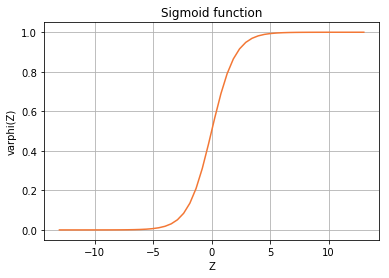

In [5]:
# Teste da Sigmoide
dom = np.linspace(-13, 13)
sig = sigmoid(dom)

plt.figure()

plt.title("Sigmoid function"); plt.xlabel("Z"); plt.ylabel(r"varphi(Z)")
plt.plot(dom, sig, color=colorpad[3])
plt.grid()

plt.show()

### Função de Predição

A segunda parte, então, consiste em implementar a função de "predição" da SLP, na qual o _potencial de rede_ é diretamente aplicado à _função de ativação_. Faremos uma condição para que a predição possa ter duas formas: a de uma probabilidade (que é a resposta natural da ativação via Sigmoide) ou seja igual ao número da classe predita (um valor binário). A segunda opção é geralmente necessárias para utilizar a Rede Neural em algumas aplicações onde a resposta da predição deve ser definitiva (em sistema de controle, por exemplo, o agente não pode tomar 80% de uma ação. Ele realiza a ação ou não!)
    
O nosso **Potencial de Rede**, representado por $S_\text{net}$, é computado como:

$$
    S_\text{net} = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n y_n
$$

Note que o resultado de $S_\text{net}$ é apenas um número. Podemos então aplicar esse resultado diretamente na função de ativação $\varphi(S_\text{net})$ para calcularmos o valor (contínuo) da ativação, que corresponden à predição $h(\mathbf{w})$:

$$
    h(\mathbf{w}) = \varphi(S_\text{net}) = \frac{1}{1 + e^{w_0 + w_1 x_1 + w_2 x_2 + ... + w_n y_n}}
$$

Para converter o valor para binários basta apenas utilizar uma estrutura condicional para converter o valor para 1 ou 0, de acordo com um certo limiar (no caso do Perceptron, utilizamos 0.5 como limiar). Para o teste abaixo, o resultado deve ser:

> Probability format:
 [  9.66097606e-07   4.37823499e-01   8.02183889e-01   9.99972464e-01]
> 
> Classification format:
 [0 0 1 1]

Lembramos que essa função pode ser implementada apenas com operações matriciais, reduzindo bastante a complexidade do código. Tente imaginar como seriam essas computações! :)


In [6]:
# Função de Predição (Ativação) de uma SLP    
def slp_predict(X, w, probs=True):
    if(X.shape[1] != w.shape[1]): 
        X = np.hstack([np.ones([X.shape[0], 1]), X])

    predictions = sigmoid(np.matmul(X, w.T))[:,0]
    
    if(probs):
        return predictions
    else:
        return (predictions >= 0.5).astype(int)

In [7]:
# Teste da Ativação
w = np.array([[4.5, 3, -2.5]])
X = np.array([[-2.7,  4.1],
              [   1,  3.1],
              [ 2.3,  4.0],
              [   0, -2.4]])

print("Probability format:\n", slp_predict(X, w))
print()
print("Classification format:\n", slp_predict(X, w, False))

Probability format:
 [  9.66097606e-07   4.37823499e-01   8.02183889e-01   9.99972464e-01]

Classification format:
 [0 0 1 1]


### Função de Cálculo de Acurácia

Em problemas de Classificação, subtrair o valor previsto do valor real não nos dá uma informação muito precisa (sobre, por exemplo, a gravidade do erro). Para avaliar a qualidade de um modelo de Classificação, existem diversas medidas. Uma bem comum, e simples, consiste na acurácia: a porcentagem de exemplos "corretamente classificados". Vamos definir essa medida como:

$$
    Acc(\theta) = 100 \times (1 - \frac{1}{m} \sum (h(\mathbf{w}) - y)^{2}) 
$$

Note que, por essa subtração, apenas os valores diferentes serão contabilizados. Dividindo essa quantidade pelo total de exemplos, $m$, teremos a porcentagem de erro; o complemento, portanto, será a porcentagem de acertos. O resultado do teste deve ser:

> Real:		[0 0 1 1 1 1 0 1 1 0]  
> Predicted:	 [0 0 1 0 1 1 1 0 1 1]  
> Model Accuracy: 60.00%


Obs.: a acurácia só será correta caso tanto $h(\mathbf{w})$ quanto $y$ sejam valores binários.

In [8]:
# Definição da Função de Cálculo de Acurácia
def accuracyFunction(X, y, w):
    Y_pred = slp_predict(X, w, False)
    return 100 * (1 - (1 / np.size(y)) * np.sum((Y_pred - y) ** 2))

In [9]:
# Teste da Acurácia
w = np.array([[4.5, 3, -2.5]])
X = np.array([[-2.7,  4.1],
              [   1,  3.1],
              [ 2.3,  4.0],
              [   1,  4.3],
              [ 1.2,  2.3],
              [  -1,    0],
              [   2,    2],
              [   1,  3.8],
              [ 0.5, -0.3],
              [   0, -2.4]])

Y_real = np.array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0])
Y_pred = slp_predict(X, w, False)

print("Real:\t\t", Y_real)
print("Predicted:\t", Y_pred)
print("Model Accuracy: {0:.2f}%".format(accuracyFunction(X, Y_real, w)))

Real:		 [0 0 1 1 1 1 0 1 1 0]
Predicted:	 [0 0 1 0 1 1 1 0 1 1]
Model Accuracy: 60.00%


---
## Parte 2 - Treinando a Rede Neural

Nós já desenvolvemos as funções auxiliares para permitir que, dado um conjunto de pesos para cada sinapse, a SLP possa realizar predições sobre um conjunto de exemplos. O que resta, então, é implementar o algoritmo que **aprenda** o melhores valores possíveis para os pesos desse conjunto. É nessa atividade que realmente podemos visualizar a _aprendizagem de máquina_.

Existem diversas formas de realizar o treinamento de parâmetros de um modelo. Esses algoritmos podem realizar essa otimização de diferentes formas dependendo do modelo adotado, da forma de avaliação utilizada, da existência ou não de restrições, da abordagem adotada, da implementação utilizada, etc. É realmente um dos pontos mais importantes de implementar um modelo de Machine Learning. Iremos treinar o _Singlelayer Perceptron_ utilizando um popular algoritmo denominado **Gradiente Descendente**.

### Gradiente Descendente

O algoritmo mais popular e simples para treinar automaticamente os parâmetros de uma Rede Neural consiste no [Gradiente Descendente](https://en.wikipedia.org/wiki/Gradient_descent). O algoritmo, basicamente, calcula o a função de Custo Total (soma dos erros individuais de cada exemplo) para um determinado conjunto de parâmetros, e então calcula o gradiente dessa função para descobrir a direção, no espaço dos parâmetros, na qual ajustar os parâmetros minimiza esse custo.

Esse método é iterativo, e os ajustes nos parâmetros são realizados até que os erro seja minimizado, o método atinja a convergência ou um limite de iterações seja atingido. Cada iteração é denominada de _época_. A implementação, para uma determinada época $i$, é representada pelos seguintes passos:

1. Realizamos a predição, $h(\mathbf{w}^{(i)})$, de todos os exemplos utilizando os pesos $\mathbf{w}^{(i)}$ para essa $i$-ésima época;  

2. Utilizando as predições, $h(\mathbf{w}^{(i)})$, e os valores reais, $\mathbf{y}$, para calcular a acurácia total do modelo (utilizando a função _accuracyFunction_) e o _Erro Quadrático Médio_ (MSE), representado pela fórmula:

    $$ 
        J(\mathbf{w}^{(i)}) = MSE^{(i)} = \cfrac{1}{m} \sum_{i=0}^n (h(\mathbf{w}) - \mathbf{y})^2 
    $$
   
   e adicionamos o resultado em um _histórico de erros_.  
   **Obs.:** O MSE é a nossa função de Custo Total, comumente representada como $J(\mathbf{w}^{(i)})$  <br>
   
3. Realizamos o passo do gradiente, atualizando os pesos $\mathbf{w}^{(i)}$ de acordo com a regra:

    $$ 
        \mathbf{w}^{(i+1)} = \mathbf{w}^{(i+1)} - \alpha \nabla J(\mathbf{w}^{(i)})
    $$
    
    onde $\alpha$ é um ajuste de escala arbitrário (geralmente um valor menor que 1) denominado _Taxa de Aprendizagem_ e $\nabla J(\mathbf{w}^{(i)})$ representa o vetor gradiente da função de Custo Total, que vale:
    
    $$ 
        \nabla J(\mathbf{w}^{(i)}) = \sum_{i=0}^n (h(\mathbf{w}) - y)x_i
    $$  <br>
    
4. Imprimimos o resultado do treinamento (valores dos pesos, acurácia, erros calculados, etc.) a cada 50 épocas;  <br>

5. Checamos se a diferença do erro anterior para o erro atual é menor que a tolerância indicada (indicando possível convergência). Se for verificada a convergência, interrompemos o laço das iterações; <br>

6. Caso não houve convergência, atualizamos as variáveis auxiliares e retornamos ao Passo 1. <br>


In [10]:
###############################
#    Treinamento do SLP    #
###############################
def slp_train(X, y, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=False):
    # Armazena as dimensões dos dados (m -> exemplos, n -> atributos)
    m = X.shape[0]; n = X.shape[1]
    
    # Define o Histórico de Erros e algumas variáveis auxiliares
    errorHist = []
    previousMSE = 0
    it = 1;
    
    # Cria um atributo extra para todos os exemplos iguais a x_0 = 1
    X = np.hstack([np.ones([m,1]), X])
    
    # Cria o vetor de pesos da Rede Neural (inicialização aleatória)
    w = np.random.randn(1, n+1)
    
    # Realiza o treino por Gradiente Descendente
    while(it <= maxIt):
        # 1. Realiza a predição h(w).
        h_w = slp_predict(X, w)
        
        # 2. Calculamos o erro MSE, a acurácia do modelo e adicionamos o resultado no histórico.
        actualMSE = (1/m) * np.sum((h_w - y) ** 2)
        actualAcc = accuracyFunction(X, y, w)
        errorHist.append(actualMSE)

        # 3. Realizamos o passo do Gradiente Descendente.
        for j in range(0,n):
            for k in range(0,m):
                w[0,j] = w[0,j] - (alpha/m) * ((h_w[k] - y[k]) * X[k,j])
        
        # 3. (Alternativo) Também é possível realizar o passo do Gradiente Descendente em uma linha 
        #    utilizando operações matriciais:
        # w -= (alpha/m) * (np.matmul(X.T, (predicts - y)))
        
        # 4. Imprimimos o resultado do treinamento a cada 50 épocas.
        if(it % 50 == 0 and verbose): 
            print("## Iteration", it, "##")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.2f}%".format(actualAcc))
            print("Weights: ", w)
            print("\n")
        
        # 5. Verificamos uma possivel convergência do treinamento, e então encerramos o laço.
        if(abs(actualMSE - previousMSE) <= tol):
            print("## Iteration", it, "##")
            print("!!! Convergence reached !!!")
            print("MSE: \t", actualMSE)
            print("Accuracy: {0:.2f}%".format(actualAcc))
            print("Weights: ", w)
            print("\n")
            break;
            
        # 6. Atualizamos as variáveis auxiliares para as próximas iterações.
        previousMSE = actualMSE
        it +=1
    
    # Fim do Treinamento
    return (w, errorHist)

---
## Parte 3 - Classificação Binária com SLP

Agora que possuímos todas as ferramentas devidamente implementadas, podemos utilizar nossa Rede Neural para aprender padrões em conjuntos de dados destinados a _Classificação_. Nesse notebook, utilizaremos um conjunto de dados artificial gerado para que possamos visualizar como se comporta essa Rede Neural.

Os dados já estão carregados como as variáveis **X_train** e **y_train**. Execute os blocos abaixo para visualizar a Rede Neural em ação. 

### Execução do Treinamento

Primeiramente, executamos o método de treinamento para obtermos o conjunto ótimo de pesos para cada sinapse. É **recomendável** que o aluno "brinque" um pouco com os parâmetros do método para entender melhor como os parâmetros influenciam no treinamento.

**Obs.:** O resultado do treinamento também depende da inicialização dos pesos das sinapses, que é aleatória, e por isso talvez seja necessário re-executar o treinamento caso os resultados não sejam bons. (Essa é uma desvantagem do Gradiente Descendente).

**Obs.2:** O método deve convergir. Caso contrário, reveja a implementação do Gradiente Descendente!

In [11]:
## EXECUÇÃO DO TREINAMENTO ##
[w, errorHist] = slp_train(X=X_train, y=y_train, alpha=0.1, verbose=False)

## Iteration 1644 ##
!!! Convergence reached !!!
MSE: 	 0.045475147183
Accuracy: 92.50%
Weights:  [[-4.3588371  0.653841   1.6317802]]




### Histórico de Erro do Treinamento

O Gradiente Descendente também possui uma característica bem legal de que a função de custo que estamos utilizando, o MSE, sempre decresce a cada iteração do treinamento, em busca do valor mínimo. Se plotarmos o histórico de erro, podemos visualizar como o treinamento se comportou durante os passos dsse método.

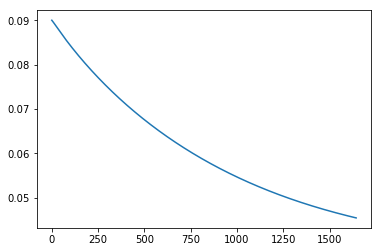

In [12]:
# VISUALIZAÇÃO DO HISTÓRICO DE ERROS ##
plt.figure()
plt.plot(errorHist)
plt.show()

### Visualização da Classificação

Agora que temos o conjunto de pesos devidamente treinados, podemos construir uma visualização para exibir como a Rede Neural está classificando os dados em todo o espaço. A função _plotContour_, que já está implementada, recebe um conjunto de pesos já treinados e classifica todos os pontos no plano de visualização. A classe atribuída a cada área corresponde à cor exibida no fundo do plano. A linha preta que divide as áreas é denominada de **Decision Boundary**, e é interpretada como a região do espaço dos exemplos em que podemos notar a divisão das classes.

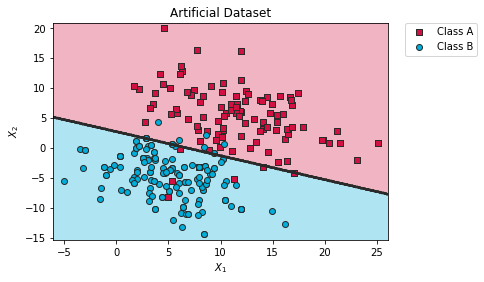

In [13]:
## VISUALIZAÇÃO DA CLASSIFICAÇÃO ##
plt.figure()

plt.title("Artificial Dataset"); plt.xlabel("$X_1$"); plt.ylabel("$X_2$")

plotContour(X_train, slp_predict, w)

a_class = np.where(y_train == 1)
b_class = np.where(y_train == 0)

plt.scatter(X_train[a_class,0], X_train[a_class,1], marker="s", color=colorpad[0], edgecolor="#2A2A2A", label="Class A")
plt.scatter(X_train[b_class,0], X_train[b_class,1], marker="o", color=colorpad[1], edgecolor="#2A2A2A", label="Class B")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()